<strong> Import all libraires that will be used </strong>

In [ ]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torchvision import transforms
from torchmetrics.image.fid import FrechetInceptionDistance

from tqdm.notebook import tqdm

from models import AttentionUNetDiscriminator, AttentionUNetGenerator
from utils import ImageDataset

<strong> Initializing the paintings dataset </strong>

In [ ]:
# Building the dataset
image_dir = '../data/anime/images_2'
image_size = 64
f = os.listdir(image_dir)[0]
print(f)
print(os.path.isfile(os.path.join(image_dir, f)))

# Transformations to normalize the data before dataloader
transform = transforms.Compose([
    transforms.Resize((image_size,image_size)), # Standardizing the size of the images
    transforms.ToTensor(), # Transforming to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # Normalizing
])


# Initializing the dataset
training_dataset = ImageDataset(image_dir, transform, limit=10000)
print(f"Dataset contains {len(training_dataset)} images")

44838_2014.jpg
True
Dataset contains 10000 images


<strong> Sampling an element from the dataset and plotting it </strong>

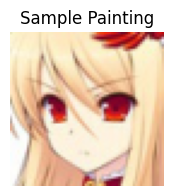

In [3]:
# Sampling randomly an element from the dataset
n = len(training_dataset)
integer = random.randint(0,n)

# Sampled image
image = training_dataset[integer].numpy()*0.5 + 0.5 # De-normalizing the image

# Plot the image
plt.figure(figsize=(3, 2))
plt.imshow(np.transpose(image, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample Painting')
plt.show()

<strong> Intializing the Dataloader </strong>

In [4]:
batch_size = 64

<strong> Initializing the parameters of the model </strong>

In [5]:
# Model's parameters
latent_dim = 100
channels_out = 3
channels_in = 3

# Intializing the models
G = AttentionUNetGenerator(latent_dim, channels_out)
D = AttentionUNetDiscriminator(3)

<strong> Sampling a vector to plot the fake image generated by the Generator </strong>

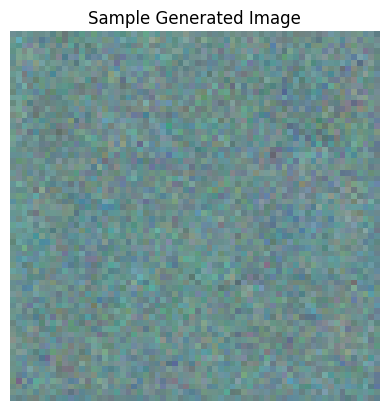

In [15]:
# Generate random noise
latent_dim = 100  # Latent space dimension

# Generate random noise
noise = torch.randn(16, latent_dim, image_size, image_size)  # Noise input for generator
# Generate images
fake_images = G(noise)  # Output shape: [16, 3, 128, 128]

# De-normalize and reshape the first generated image
image_generated = fake_images[0].detach().cpu().numpy()  # Select first image in batch
image_generated = image_generated * 0.5 + 0.5  # De-normalize to [0, 1]

# Plot the image
plt.imshow(np.transpose(image_generated, (1, 2, 0)))  # Convert to (H, W, C)
plt.axis('off')  # Hide axes
plt.title('Sample Generated Image')
plt.show()

<strong> Let build the training loop</strong>

In [16]:
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights

def diversity_loss(fake_images, feature_extractor):
    # Extract features using a pretrained model
    features = feature_extractor(fake_images)  # Shape: (batch_size, feature_dim)

    # Normalize features to unit vectors
    features = F.normalize(features, p=2, dim=1)

    # Compute pairwise cosine similarity
    similarity_matrix = torch.matmul(features, features.T)  # Shape: (batch_size, batch_size)

    # Remove diagonal elements (self-similarity)
    batch_size = similarity_matrix.size(0)
    mask = torch.eye(batch_size, device=similarity_matrix.device).bool()
    diversity_penalty = similarity_matrix.masked_fill(mask, 0).mean()

    return diversity_penalty

In [17]:
def gradient_penalty(D, real, fake,device='cuda'):
    # Compute random weight for interpolation
    alpha = torch.rand(real.size(0), 1, 1, 1).to(device)

    # Interpolate real and fake images
    interpolated = (alpha * real + (1 - alpha) * fake).requires_grad_()

    # Compute output of the critic
    prob_interpolated = D(interpolated)

    # Compute gradients of the critic with respect to the interpolated images
    gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                                    grad_outputs=torch.ones_like(prob_interpolated),
                                    create_graph=True, retain_graph=True)[0]

    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(p=2, dim=1) - 1) ** 2).mean()

    return gradient_penalty


In [ ]:

torch.autograd.set_detect_anomaly(True)

loss_options = ["w","bce"]
loss_option = loss_options[0]

image_size = 64
experiment = 3

output_dir = f"training_samples/wgan/experiment_{experiment}"
os.makedirs(output_dir, exist_ok=True)

# Parameters
input_channels = 3
channels_out = input_channels
n_classes = 2
k = 2  # number of critic updates per generator update
latent_dim = 256
training_steps = 50000 # Number of training steps
epochs = 1 # Number of epochs
lambda_gp = 10  # Gradient penalty weight
lambda_div = 5  # Diversity loss weight

d_lr = 1e-4 if loss_option == "w" else 2e-4  # Base learning rate
g_lr = 2e-4 if loss_option == "w" else 2e-4  # Base learning rate


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# feature extractor to compute diversity loss
feature_extractor = resnet18(weights=ResNet18_Weights.DEFAULT)
feature_extractor.eval().to(device)

# Initialize models (Use Attention U-Net GAN models)
G_attention = AttentionUNetGenerator(latent_dim, channels_out).to(device)  # Latent space maps to input

if loss_option == "w":
    D_attention = AttentionUNetDiscriminator(input_channels, features=64, use_sigmoid=False).to(device)  # Wasserstein discriminator
elif loss_option == "bce":
    D_attention = AttentionUNetDiscriminator(input_channels, features=64).to(device)  # PatchGAN discriminator

# Loss function and optimizers
if loss_option == "bce":
    criterion = torch.nn.BCELoss()  # Binary Cross-Entropy for GANs

optimizer_g = torch.optim.Adam(G_attention.parameters(), lr=g_lr, betas=(0.0, 0.9) if loss_option == "w" else (0.5, 0.999))
optimizer_d = torch.optim.Adam(D_attention.parameters(), lr=d_lr, betas=(0.0, 0.9) if loss_option == "w" else (0.5, 0.999))

# FID Evaluation setup
epoch_fid = 100  # Evaluate FID every `epoch_eval` epochs
epoch_sampling = 10 # Save generated samples every `epoch_sampling` epochs


fid = FrechetInceptionDistance(feature=192, reset_real_features=False, normalize=True)
n_samples = 1000

# Ensure your dataset of real paintings is available
N = len(training_dataset)  # Assuming `paintings` is a tensor of real images
# Batch update the FID score


indices = random.sample(range(N), n_samples)
real_images_eval = torch.stack([training_dataset[idx] for idx in indices])
for i in range(0, n_samples, batch_size):
    real_images_chunk = real_images_eval[i:i+batch_size].to('cpu')
    fid.update(real_images_chunk, real=True)

del real_images_eval
# Track losses and FID values
FID_values = []
D_loss = []
G_loss = []

dataloader = DataLoader(training_dataset, batch_size=128)
# Training loop
for epoch in tqdm(range(1, epochs+1)):

    start_time = time.time()
    
    generator_count = 0
    generator_loss = 0
    
    critic_count = 0
    critic_loss = 0
    
    for batch in tqdm(dataloader):
        ################################################################
        # 1) CRITIC (DISCRIMINATOR) UPDATES 
        ################################################################
        
        # Get next batch of real images
        real_images = batch.to(device)
        curr_batch_size = real_images.size(0)

        # Possibly create BCE labels if using BCE
        if loss_option == "bce":
            
            labels_real = torch.full((curr_batch_size, 1), 0.9, device=device)
            labels_fake = torch.full((curr_batch_size, 1), 0.1, device=device)

        # Zero grad for D
        optimizer_d.zero_grad()

        # Optionally add small noise to real images
        # real_noisy = real_images + torch.randn_like(real_images) * 0.01

        # ----- 1(a): Discriminator loss on real
        if loss_option == "w":
            output_real = D_attention(real_images).view(-1)
            loss_d_real = -output_real.mean()
        else:  # BCE
            output_real = D_attention(real_images).view(-1, 1)
            loss_d_real = criterion(output_real, labels_real)

        # ----- 1(b): Discriminator loss on fake
        noise = torch.randn(curr_batch_size, latent_dim, image_size, image_size, device=device)
        fake_images = G_attention(noise).detach()  # detach so G is not updated here

        # fake_noisy = fake_images + torch.randn_like(fake_images) * 0.01

        if loss_option == "w":
            output_fake = D_attention(fake_images).view(-1)
            loss_d_fake = output_fake.mean()
        else:  # BCE
            output_fake = D_attention(fake_images).view(-1, 1)
            loss_d_fake = criterion(output_fake, labels_fake)

        # ----- 1(c): Gradient Penalty
        gp = gradient_penalty(D_attention, real_images, fake_images, device=device) 
        # gradient_penalty(...) is assumed to return scalar

        # Combine D losses
        loss_d = loss_d_real + loss_d_fake + lambda_gp * gp
        
        # Backprop and step
        loss_d.backward()
        optimizer_d.step()
        
        # Track critic loss
        critic_loss += loss_d.item()
        critic_count += 1


        ################################################################
        # 2) GENERATOR UPDATE (every k steps of critic)
        ################################################################
        
        if critic_count % k == 0: # Only update G every k steps
            # Freeze D's parameters
            for p in D_attention.parameters():
                p.requires_grad = False

            # We'll generate a new batch of noise/images
            noise = torch.randn(batch_size, latent_dim, image_size, image_size, device=device)
            fake_images = G_attention(noise)
            
            # Zero grad for G
            optimizer_g.zero_grad()

            if loss_option == "w":
                output_fake_for_gen = D_attention(fake_images).view(-1)
                loss_g = -output_fake_for_gen.mean()
            else:  # BCE
                labels_real = torch.full((batch_size, 1), 0.9, device=device)
                output_fake_for_gen = D_attention(fake_images).view(-1, 1)
                loss_g = criterion(output_fake_for_gen, labels_real)

            # Diversity penalty (optional)
            diversity_pen = diversity_loss(fake_images, feature_extractor)
            loss_g += lambda_div * diversity_pen

            # Backprop and step
            loss_g.backward()
            optimizer_g.step()

            # Re-enable D grads for next iteration
            for p in D_attention.parameters():
                p.requires_grad = True
                
            # Track generator loss
            generator_loss += loss_g.item()
            generator_count += 1


    # Evaluate FID every `epoch_eval` epochs
    if epoch % epoch_fid == 0:
        G_attention.eval()  # Set generator to eval mode for FID computation
        with torch.no_grad():
        # Generate evaluation images
            noise_eval = torch.randn(n_samples, latent_dim, image_size, image_size, device=device)
            for i in range(0, n_samples, batch_size):
                fake_images_chunk = G_attention(noise_eval[i:i+batch_size]).to('cpu')
                fid.update(fake_images_chunk, real=False)

            fid_value = fid.compute().item()
            FID_values.append(fid_value)

            print(f'FID after epoch {epoch}: {fid_value}')

        torch.cuda.empty_cache()
        fid.reset()
        G_attention.train()
        
    if epoch % epoch_sampling == 0:
        G_attention.eval()  # Set generator to eval mode for FID computation
        
        # Generate evaluation images
        with torch.no_grad():
            noise_eval = torch.randn(64, latent_dim, image_size, image_size, device=device)
            fake_images_eval = G_attention(noise_eval).to(torch.device('cpu'))
        
        # Save a grid of generated samples
        grid = vutils.make_grid(fake_images_eval, normalize=True, scale_each=True)
        sample_path = os.path.join(output_dir, f"epoch_{epoch:03d}.png")
        vutils.save_image(grid, sample_path)
        print(f"Sample images saved to {sample_path}")
        
        del fake_images_eval
        torch.cuda.empty_cache()
        G_attention.train()
        
    # Track losses
    print(f'generator_count: {generator_count}, critic_count: {critic_count}')
    generator_loss = generator_loss/generator_count
    critic_loss = critic_loss/critic_count
    
    D_loss.append(critic_loss)
    G_loss.append(generator_loss)


    end_time = time.time()
    
    print(f'Epoch [{epoch }/{epochs}] | Loss D: {critic_loss} | Loss G: {generator_loss} | Wasserstein Distance: { - critic_loss - generator_loss}')
    print(f'Epoch duration: {end_time - start_time:.2f}s')
    


cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [1/1000] | Loss D: -0.2277401059488707 | Loss G: -3.811175982157389 | Wasserstein Distance: 4.03891608810626
Epoch duration: 40.92s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [2/1000] | Loss D: -4.117902978311611 | Loss G: 6.2019202709198 | Wasserstein Distance: -2.0840172926081886
Epoch duration: 40.84s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [3/1000] | Loss D: -1.6779546499063698 | Loss G: 3.8400988578796387 | Wasserstein Distance: -2.162144207973269
Epoch duration: 39.72s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [4/1000] | Loss D: -1.315876172218896 | Loss G: 3.957182364586072 | Wasserstein Distance: -2.6413061923671757
Epoch duration: 40.88s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [5/1000] | Loss D: -1.7178092990542138 | Loss G: 3.7828602546300645 | Wasserstein Distance: -2.0650509555758507
Epoch duration: 41.20s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [6/1000] | Loss D: -0.8876587520766107 | Loss G: 0.7724487689825205 | Wasserstein Distance: 0.11520998309409025
Epoch duration: 39.04s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [7/1000] | Loss D: -0.8798949879747403 | Loss G: 1.6972161210500276 | Wasserstein Distance: -0.8173211330752873
Epoch duration: 37.87s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [8/1000] | Loss D: -0.8190952529069744 | Loss G: 1.0272103013136449 | Wasserstein Distance: -0.2081150484066705
Epoch duration: 37.82s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [9/1000] | Loss D: -0.5826758178351801 | Loss G: 1.9520361056694617 | Wasserstein Distance: -1.3693602878342817
Epoch duration: 37.95s


  0%|          | 0/79 [00:00<?, ?it/s]

Sample images saved to training_samples/experiment_3\epoch_010.png
generator_count: 39, critic_count: 79
Epoch [10/1000] | Loss D: -0.8942236621168596 | Loss G: 1.757640534486526 | Wasserstein Distance: -0.8634168723696665
Epoch duration: 39.03s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [11/1000] | Loss D: -0.8266489258672618 | Loss G: 1.0285615630638905 | Wasserstein Distance: -0.20191263719662866
Epoch duration: 39.22s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [12/1000] | Loss D: -0.6468903705289092 | Loss G: 1.273344101049961 | Wasserstein Distance: -0.6264537305210519
Epoch duration: 38.27s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [13/1000] | Loss D: -0.6572001761273493 | Loss G: 1.4717917900819044 | Wasserstein Distance: -0.8145916139545551
Epoch duration: 37.67s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [14/1000] | Loss D: -0.8206389478490322 | Loss G: 1.5530028220934746 | Wasserstein Distance: -0.7323638742444424
Epoch duration: 38.98s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [15/1000] | Loss D: -0.7874048325834395 | Loss G: 0.470294394554236 | Wasserstein Distance: 0.3171104380292035
Epoch duration: 39.27s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [16/1000] | Loss D: -0.8994920181605635 | Loss G: 0.4557963189406273 | Wasserstein Distance: 0.4436956992199362
Epoch duration: 38.85s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [17/1000] | Loss D: -0.7835186047927488 | Loss G: 0.8955814242362976 | Wasserstein Distance: -0.11206281944354879
Epoch duration: 39.53s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [18/1000] | Loss D: -0.7170617963317074 | Loss G: 0.6709174949389237 | Wasserstein Distance: 0.04614430139278369
Epoch duration: 38.16s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [19/1000] | Loss D: -0.5235815148187589 | Loss G: 1.0159966288468776 | Wasserstein Distance: -0.49241511402811866
Epoch duration: 38.92s


  0%|          | 0/79 [00:00<?, ?it/s]

Sample images saved to training_samples/experiment_3\epoch_020.png
generator_count: 39, critic_count: 79
Epoch [20/1000] | Loss D: -0.6745935636513596 | Loss G: 0.8483649614529732 | Wasserstein Distance: -0.17377139780161366
Epoch duration: 38.95s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [21/1000] | Loss D: -0.6172457087926472 | Loss G: 0.865706362021275 | Wasserstein Distance: -0.24846065322862787
Epoch duration: 38.79s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [22/1000] | Loss D: -0.7263711184451852 | Loss G: 1.098711643463526 | Wasserstein Distance: -0.3723405250183408
Epoch duration: 41.17s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [23/1000] | Loss D: -0.7588151441061799 | Loss G: 1.0408879640774849 | Wasserstein Distance: -0.28207281997130496
Epoch duration: 38.87s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [24/1000] | Loss D: -0.7348582662076135 | Loss G: 0.8250492482613294 | Wasserstein Distance: -0.0901909820537159
Epoch duration: 39.30s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [25/1000] | Loss D: -0.6431730010228444 | Loss G: 0.6175954739252726 | Wasserstein Distance: 0.025577527097571773
Epoch duration: 38.66s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [26/1000] | Loss D: -0.615586587333981 | Loss G: 0.5823163649974725 | Wasserstein Distance: 0.03327022233650845
Epoch duration: 39.16s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [27/1000] | Loss D: -0.6453556125582773 | Loss G: 0.4814115426479242 | Wasserstein Distance: 0.16394406991035315
Epoch duration: 38.41s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [28/1000] | Loss D: -0.7048924889745591 | Loss G: 0.6778184427664831 | Wasserstein Distance: 0.027074046208076075
Epoch duration: 38.29s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [29/1000] | Loss D: -0.6743158553785915 | Loss G: 0.39675773718418217 | Wasserstein Distance: 0.27755811819440934
Epoch duration: 38.50s


  0%|          | 0/79 [00:00<?, ?it/s]

Sample images saved to training_samples/experiment_3\epoch_030.png
generator_count: 39, critic_count: 79
Epoch [30/1000] | Loss D: -0.6926996754600278 | Loss G: 1.0752361623140483 | Wasserstein Distance: -0.38253648685402053
Epoch duration: 38.82s


  0%|          | 0/79 [00:00<?, ?it/s]

generator_count: 39, critic_count: 79
Epoch [31/1000] | Loss D: -0.7289040233656953 | Loss G: 0.4862204637282934 | Wasserstein Distance: 0.24268355963740185
Epoch duration: 38.53s


  0%|          | 0/79 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
torch.save(D_attention.state_dict(), f"weights/d_att_{experiment}.pth")
torch.save(G_attention.state_dict(), f"weights/g_att_{experiment}.pth")

In [20]:
experiment = 2
latent_dim = 128
channels_out = 3
G_unet_test = AttentionUNetGenerator(latent_dim, channels_out)
G_unet_test.load_state_dict(torch.load(f"weights/g_att_{experiment}.pth"))

<All keys matched successfully>

<strong> Generating some examples using the trained generator </strong>

torch.Size([1, 3, 64, 64])


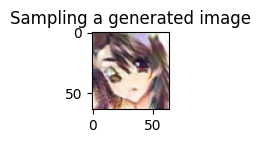

In [10]:
# Generate random noise
noise = torch.randn(1, latent_dim, image_size, image_size)  # Batch of 16 noise vectors

# Generate images
fake_images = G_unet_test(noise)

print(fake_images.size())  # Should be (16, img_channels, height, width)

image_noise = fake_images.detach().numpy().reshape((3,image_size,image_size))*0.5 + 0.5

plt.figure(figsize=(2, 1))
plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.title("Sampling a generated image")
plt.show()

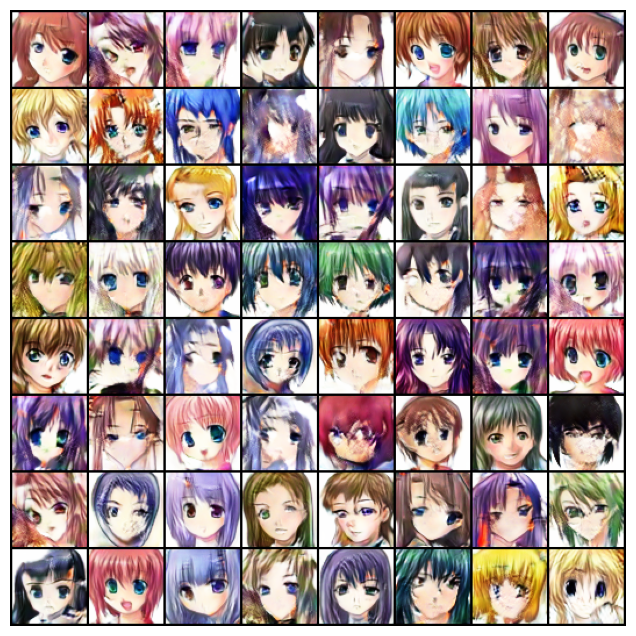

In [38]:
image_size = 64
noise_eval = torch.randn(64, latent_dim, image_size, image_size, device=torch.device('cpu'))
G_unet_test.eval()  # Set generator to eval mode for sampling
fake_images_eval = G_unet_test(noise_eval).to(torch.device('cpu'))

# Save a grid of generated samples
grid = vutils.make_grid(fake_images_eval, normalize=True, scale_each=True)
np_grid = grid.permute(1, 2, 0).numpy()

# Display the images
plt.figure(figsize=(8, 8))
plt.imshow(np_grid)
plt.axis('off')  # Turn off axis
plt.show()

<strong> Plotting Losses <strong>

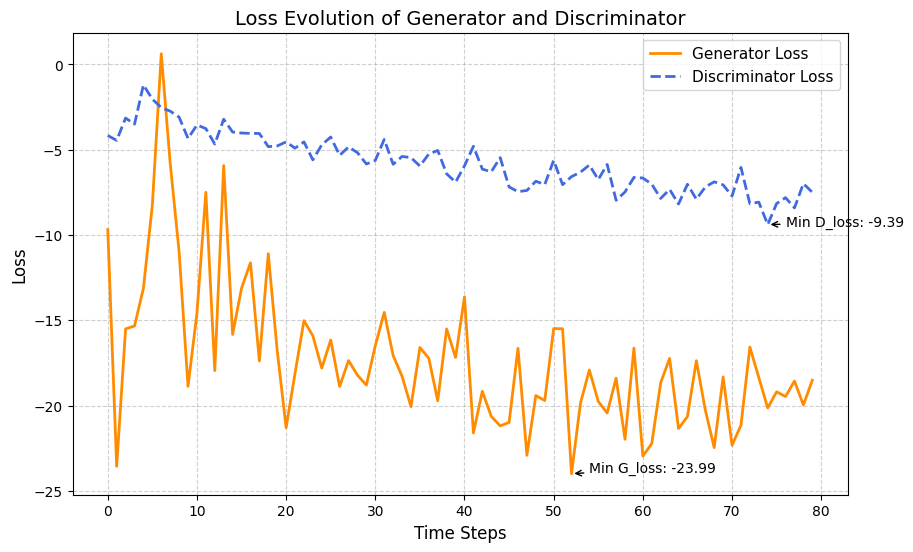

In [ ]:
# Assuming G_loss and D_loss are defined
ng = len(G_loss)
nd = len(D_loss)
time_steps_g = [i for i in range(ng)]
time_steps_d = [i for i in range(nd)]


plt.figure(figsize=(10, 6))

# Plot Generator Loss
plt.plot(time_steps_g, G_loss, label='Generator Loss', color='darkorange', linestyle='-', linewidth=2)

# Plot Discriminator Loss
plt.plot(time_steps_d, D_loss, label='Discriminator Loss', color='royalblue', linestyle='--', linewidth=2)

# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Evolution of Generator and Discriminator', fontsize=14)

# Adding legend
plt.legend(loc='upper right', fontsize=11)

# Adding annotations for minimum loss points (optional)
min_G_loss = min(G_loss)
min_G_loss_idx = G_loss.index(min_G_loss)
plt.annotate(f'Min G_loss: {min_G_loss:.2f}', xy=(min_G_loss_idx, min_G_loss),
             xytext=(min_G_loss_idx + n*0.1, min_G_loss + max(G_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

min_D_loss = min(D_loss)
min_D_loss_idx = D_loss.index(min_D_loss)
plt.annotate(f'Min D_loss: {min_D_loss:.2f}', xy=(min_D_loss_idx, min_D_loss),
             xytext=(min_D_loss_idx + n*0.1, min_D_loss + max(D_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

# Show plot
plt.show()

<strong> Plotting FID values <strong>

Text(0.5, 1.0, 'FID Evolution through training')

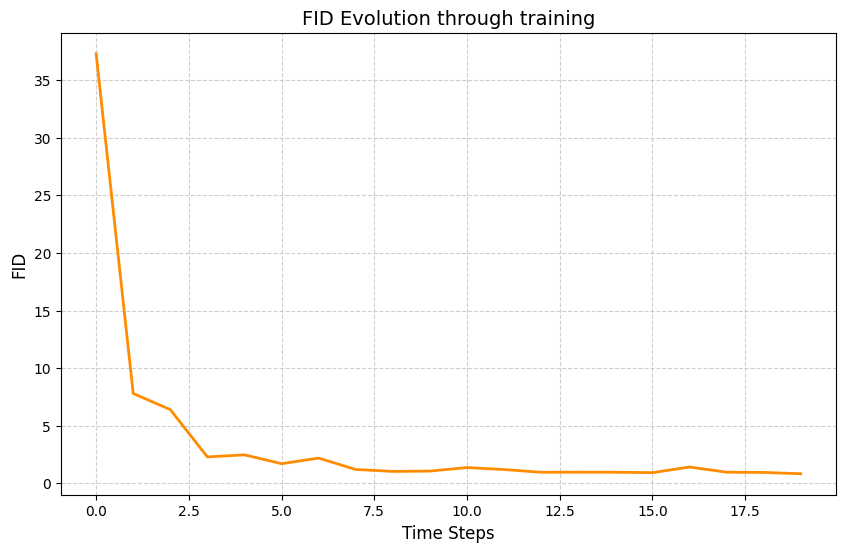

In [13]:
n = len(FID_values)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot FID values
plt.plot(time_steps, FID_values, label='Generator FID', color='darkorange', linestyle='-', linewidth=2)


# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('FID', fontsize=12)
plt.title('FID Evolution through training', fontsize=14)

In [14]:
# Save G_loss and D_loss to text files
np.savetxt(f'plots/g_loss_{experiment}.txt', np.array(G_loss))
np.savetxt(f'plots/d_loss_{experiment}.txt', np.array(D_loss))

# Load G_loss and D_loss from text files
loaded_g_loss = np.loadtxt(f'plots/g_loss_{experiment}.txt')
loaded_d_loss = np.loadtxt(f'plots/d_loss_{experiment}.txt')

In [15]:
# Save FID values to a text file
np.savetxt(f'plots/fid_values_{experiment}.txt', np.array(FID_values))

# Load FID values from a text file
loaded_fid_values = np.loadtxt(f'plots/fid_values_{experiment}.txt')
print(loaded_fid_values)

[37.29192734  7.79943132  6.39948893  2.29505491  2.47268558  1.70718801
  2.19171     1.20318317  1.03526342  1.06450415  1.3687607   1.19921172
  0.96061331  0.97028887  0.96526223  0.92675114  1.41838992  0.9690119
  0.94587034  0.83528078]
